# MedicalNIST the most basic prediction technique

> Breaking the ice post - let's start blogging about medical imaging :)

- toc: false 
- badges: true
- comments: true
- categories: [medicalnist, mnist, basic]

To start off the blog, I've chosen the most basic example I could come up with:

Medical imaging categorization based on comparison between the "statistically average" image from a category and a set of test images.

This will be used to build upon using more advanced techniques, so stay tuned!

But first let's download the data

In [5]:
! rm -rf ./medical_mnist
! git clone https://github.com/apolanco3225/Medical-MNIST-Classification.git
! mv Medical-MNIST-Classification/resized/ ./medical_mnist
! rm -rf Medical-MNIST-Classification

Cloning into 'Medical-MNIST-Classification'...
remote: Enumerating objects: 58532, done.
remote: Total 58532 (delta 0), reused 0 (delta 0), pack-reused 58532
Receiving objects: 100% (58532/58532), 77.86 MiB | 4.39 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Checking connectivity... done.
Checking out files: 100% (58959/58959), done.


install useful libraries

In [6]:
## run this if you don't have pytorch and fastai2 installed
# !pip install torch torchvision

data will be downloaded to `medical_mnist` folder

In [7]:
from pathlib import Path

data = Path('medical_mnist')
list(data.iterdir())

[PosixPath('medical_mnist/AbdomenCT'),
 PosixPath('medical_mnist/BreastMRI'),
 PosixPath('medical_mnist/CXR'),
 PosixPath('medical_mnist/ChestCT'),
 PosixPath('medical_mnist/Hand'),
 PosixPath('medical_mnist/HeadCT')]

let's see what we have here... as this is the most basic technique, let's pick the images that look the most different from each other

medical_mnist/AbdomenCT


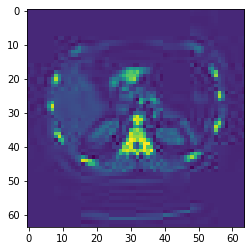

medical_mnist/BreastMRI


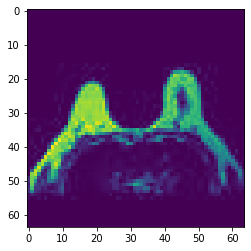

medical_mnist/CXR


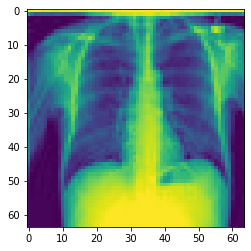

medical_mnist/ChestCT


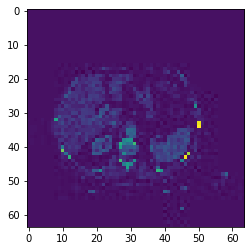

medical_mnist/Hand


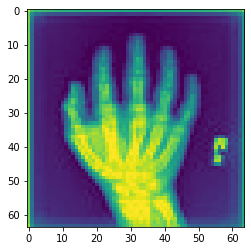

medical_mnist/HeadCT


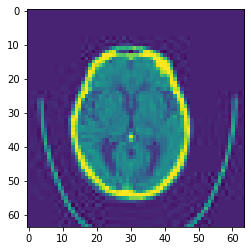

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

for d in data.iterdir():
    print(d)
    plt.imshow(Image.open(list(d.iterdir())[0]))
    plt.show()

load the data into tensors

In [9]:
import torch
from torchvision.transforms import ToTensor

stacked_cxrs = torch.stack([ToTensor()(Image.open(path)).float()/255 for path in (data/'CXR').iterdir()])
stacked_heads = torch.stack([ToTensor()(Image.open(path)).float()/255 for path in (data/'HeadCT').iterdir()])

as a good practice, let's look at the first image, so see if we did it correctly

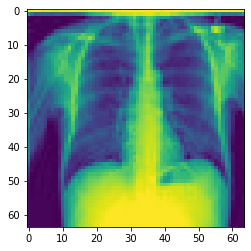

In [10]:
plt.imshow(stacked_cxrs[0][0])

now, let's build "ideal" image for each of the category. This ideal image is just a mean for each pixel across all the images

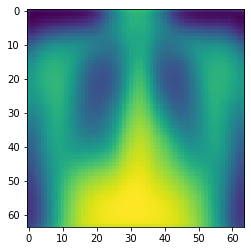

In [11]:
mean_cxrs = stacked_cxrs.mean(0)

plt.imshow(mean_cxrs[0])

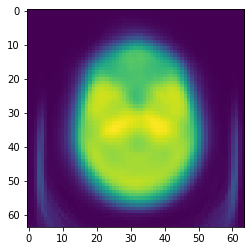

In [12]:
mean_headct = stacked_heads.mean(0)

plt.imshow(mean_headct[0])

now we can see how much example image differs from the ideals:

In [13]:
import torch.nn.functional as F

In [14]:
F.mse_loss(stacked_cxrs[0], mean_cxrs).sqrt()

tensor(0.0010)

In [15]:
F.mse_loss(stacked_cxrs[0], mean_headct).sqrt()

tensor(0.0016)

looks like that one was a CXR indeed - L2 loss between ideal image from CXR category (mean_cxrs) was lower

so let's build a simple classifier function, that predicts whether image is a headct or not

In [16]:
def is_headct(img_tensor):
    if F.mse_loss(img_tensor, mean_cxrs) > F.mse_loss(img_tensor, mean_headct):
        return True
    else:
        return False

now we test the classifier

In [17]:
cxrs_preds = torch.tensor([not is_headct(stacked_cxrs[i]) for i in range(stacked_cxrs.shape[0])])
cxrs_accuracy = cxrs_preds.sum().float() / cxrs_preds.shape[0]
print(f'Accuracy on CXRs: {round( (cxrs_accuracy).item() * 100, 2)}%')

Accuracy on CXRs: 99.15%


In [18]:
head_preds = torch.tensor([is_headct(stacked_heads[i]) for i in range(stacked_heads.shape[0])])
head_accuracy = head_preds.sum().float() / head_preds.shape[0]
print(f'Accuracy on HeadCTs: {round( (head_accuracy).item() * 100, 2)}%')

Accuracy on HeadCTs: 100.0%


... of course:
 1. those classes were the most distinguishable from each other and
 1. we didn't split into `train` and `test` sets here so results are biased (as each image we predict was used to figure out the "ideal" image)

but this was a nice start of this blog :)